# Import Dependencies

In [1]:
import torch
from torch.types import Tensor
import time

import torch.nn.functional as F
import torch.nn as nn
from torch.nn import MSELoss

from torch.optim import Adam, SGD, Adadelta, RMSprop

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.optimize import minimize
# from pymoo.problems import get_problem
from pymoo.core.problem import Problem

from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.nsga2 import NSGA2

from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

from pymoo.core.problem import Problem
from pymoo.core.result import Result

from pymoo.optimize import minimize

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.patches as patches
import seaborn as sns

from pymoo.config import Config
Config.warnings['not_compiled'] = False

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Make Data & Environmet & Practical Function

In [3]:

def generate_structured_environment(size_cm, num_blocks=5, block_size_range=(5, 20)):
	"""
	size_cm: tuple[int] مثل (100, 100)
	dimension: 2 یا 3
	num_blocks: تعداد ساختارهای مانعی (مثل دیوار یا ستون)
	block_size_range: حداقل و حداکثر اندازه‌ی هر مانع (به سانتی‌متر)
	seed: مقدار تصادفی ثابت برای reproducibility
	
	خروجی: تنسور محیط با 0 و 1
	"""
	# import torch
	# import numpy as np
	# if seed is not None:
	#     torch.manual_seed(seed)
	#     np.random.seed(seed)

	dimension = len(size_cm)
	if dimension == 2:
		H, W = size_cm
		env = torch.zeros((H, W), dtype=torch.float32)
	elif dimension == 3:
		H, W, D = size_cm
		env = torch.zeros((H, W, D), dtype=torch.float32)
	else:
		raise ValueError("Only 2D or 3D is supported.")

	for _ in range(num_blocks):
		if dimension == 2:
			h = np.random.randint(block_size_range[0], block_size_range[1])
			w = np.random.randint(block_size_range[0], block_size_range[1])
			x = np.random.randint(0, H - h)
			y = np.random.randint(0, W - w)
			env[x:x+h, y:y+w] = 1.0  # مانع مستطیلی
		else:
			h = np.random.randint(block_size_range[0], block_size_range[1])
			w = np.random.randint(block_size_range[0], block_size_range[1])
			d = np.random.randint(block_size_range[0], block_size_range[1])
			x = np.random.randint(0, H - h)
			y = np.random.randint(0, W - w)
			z = np.random.randint(0, D - d)
			env[x:x+h, y:y+w, z:z+d] = 1.0  # مانع مکعبی

	return env


def nodes_pose_generate(num_pop : int, num_node : int = 5, dimension : int = 2):
	X = torch.rand(num_pop, num_node, dimension, requires_grad=True)
	return X

def denormalize_positions(X_norm: Tensor, size_cm: tuple[int, int] | tuple[int, int, int] | torch.Size) -> Tensor:
	"""
	X_norm: تنسور با مقادیر نرمالیزه شده بین 0 و 1، shape = [..., D] که D ≥ 2
	size_cm: اندازه محیط (مثلا (100, 100))؛ فقط روی ستون‌های اول و دوم اعمال می‌شود
	"""
	if len(size_cm) == 2:
		size_tensor = torch.tensor([size_cm[0] - 1, size_cm[1] - 1], dtype=X_norm.dtype, device=X_norm.device)
	elif len(size_cm) == 3:
		size_tensor = torch.tensor([size_cm[0] - 1, size_cm[1] - 1, size_cm[2] - 1], dtype=X_norm.dtype, device=X_norm.device)
	else:
		raise ValueError("size_cm must be of length 2 or 3.")

	# فقط ستون‌های مربوطه ضرب می‌شن، بقیه دست نخورده می‌مونن
	out = X_norm.clone()
	out[..., :len(size_tensor)] = out[..., :len(size_tensor)] * size_tensor

	# print("out ",out.dim())
	try:
		threshold = torch.tensor(.5) #out[...,2].mean() + out[...,2].std()
		mask = out[..., 2] > threshold
		filtered = out[mask]
	except:
		filtered = out
	return filtered.float()


def positioning_nodes(env : Tensor , nodes_pose : Tensor , defines_as : int = 2):
	env_prime = env.clone()
	nodes_pose = nodes_pose.int()
	for pos in nodes_pose:
		if defines_as == 3 and env_prime[pos[0], pos[1]] == 1:
			print(f"Position {pos} is already occupied in the environment.", )
		else:
			env_prime[pos[0], pos[1]] = defines_as
	return env_prime


def find_best(X: Tensor | list, 
			  fn: nn.Module,
			  best_as: str = "min",
			  verbose: bool = True) -> Tensor:
	if best_as not in ["min", "max"]:
		raise ValueError("best_as must be either 'min' or 'max'.")

	best_fn = {
		"min": torch.argmin,
		"max": torch.argmax
	}

	# استفاده از stack به‌جای tensor
	values = torch.stack([fn(i).mean() for i in X])
	# print(values.unique())
	best_answer_index = best_fn[best_as](values)

	if verbose:
		print(f"Best Answer is in index: {best_answer_index.item()}")

	return X[best_answer_index]


def generate_IDX(X, L, Sup, Cov, R_c, R_s):
	"""
	تولید IDX با محاسبه برداری فاصله‌ها با torch.cdist
	
	پارامترها:
	X: تانسور موقعیت گره‌ها با شکل (num_nodes, D)
	L: پارامتر محلی‌سازی (حداکثر فاصله مجاز)
	Sup: ماتریس پشتیبان (num_nodes, num_nodes)
	Cov: ماتریس پوشش (num_targets, num_nodes)
	"""
	num_nodes = X.shape[0]
	IDX = []
	
	# محاسبه ماتریس فاصله‌های جفتی (num_nodes, num_nodes)
	dist_matrix = torch.cdist(X, X, p=2)  # p=2 برای فاصله اقلیدسی
	
	# ایجاد ماسک برای شرط فاصله (فاصله <= L و i != j)
	mask_distance = (dist_matrix <= L) & (~torch.eye(num_nodes, dtype=torch.bool, device=X.device))
	
	# بررسی تعارض نقش‌ها برای هر جفت گره
	for i, j in torch.nonzero(mask_distance, as_tuple=False):
		i, j = i.item(), j.item()
		
		# بررسی پشتیبانی مشترک: آیا هر دو گره i و j پشتیبان یک گره سوم هستند؟
		common_support = (Sup[:, i] == 1) & (Sup[:, j] == 1)
		if common_support.any():
			continue
		
		# بررسی پوشش مشترک: آیا هر دو گره i و j پوشش‌دهنده یک هدف هستند؟
		common_cover = (Cov[:, i] == 1) & (Cov[:, j] == 1)
		if common_cover.any():
			continue
		
		IDX.append((i, j))
	
	return torch.tensor(IDX)


def Sup(X : Tensor, con_rate : int | Tensor) -> Tensor:
	dist_matrix_0 = torch.cdist(X, X, p=2)
	dist_matrix = dist_matrix_0[dist_matrix_0.triu(0) !=  0]
	dist_matrix = dist_matrix[dist_matrix <= con_rate *2 ]
	support : Tensor = torch.nonzero(torch.isin(dist_matrix_0, dist_matrix))#.unique(dim=0)
	return support


def Cov(X : Tensor, TP: Tensor | None, cov_rate : float | Tensor) -> Tensor :
	X = X[...,:2]
	if TP is not None:
		dist_matrix_0 = torch.cdist(X, TP, p=2)
		# print(dist_matrix_0.tril(1))
		dist_matrix = dist_matrix_0[dist_matrix_0.tril(1) != 0]
		dist_matrix = dist_matrix[dist_matrix <= cov_rate]
		coverage = torch.nonzero(torch.isin(dist_matrix_0, dist_matrix))#.unique(dim=0)
		return coverage
	else:
		return torch.empty([1])
	


# Visulizer Functions

In [4]:

def plot_2d_environment(env_tensor: Tensor, 
						cov_rate : int | Tensor ,
						con_rate : int | Tensor,
						# cov_radius: Tensor | None = None,
						# con_radius: Tensor | None = None,
						edit : str | None = None):
	"""
	env_tensor: ماتریس 2D که مقادیر:
		0: فضای آزاد
		1: مانع
		2: سنسور
		3: علامت ستاره

	cov_radius: تنسور 1D به طول تعداد سنسورها (2ها)، شامل شعاع‌های دایره‌ی توخالی دور هر سنسور
	"""

	H, W = env_tensor.shape
	plt.figure(figsize=(6, 6))
	plt.imshow((env_tensor == 1).numpy(), cmap='Greys', origin='upper')  # فقط موانع

	num_seneors: int = (env_tensor == 2).sum().item() # type: ignore
	cov_radius: Tensor = torch.ones(size=(num_seneors,)) * cov_rate  # torch.randint(low=5, high=10, size=(Num_Sensor_Node,))
	con_radius = torch.ones(size=(num_seneors,)) * con_rate  # torch.randint(low=5, high=10, size=(Num_Sensor_Node,))

	ax = plt.gca()
	sensor_indices = []
	target_indices = []

	for y in range(H):
		for x in range(W):
			val = env_tensor[y, x].item()
			if val == 2:
				plt.plot(x, y, 'ro', markersize=8, label='Sensor' if not sensor_indices else "")
				sensor_indices.append((x, y))
			elif val == 3:
				plt.plot(x, y, 'b*', markersize=12, label=f'target' if not target_indices else "")
				target_indices.append((x,y))
			elif val == 4:
				plt.plot(x, y, 'g^', markersize=10, label='sink')

	# اضافه‌کردن دایره‌های توخالی بر اساس شعاع‌ها
	if cov_radius is not None:
		assert len(cov_radius) == len(sensor_indices), "طول cov_radius باید با تعداد سنسورها (2ها) برابر باشد."
		for (x, y), Cov_rate in zip(sensor_indices, cov_radius):
			circle1 = patches.Circle(xy=(x, y),radius= Cov_rate.item(), fill=False, edgecolor='r', linestyle='--', linewidth=1.5)
			ax.add_patch(circle1)
		circle1.set_label("Coverrage rate")
	# اضافه‌کردن دایره‌های توخالی بر اساس شعاع‌ها
	if con_radius is not None:
		assert len(con_radius) == len(sensor_indices), "طول con_radius باید با تعداد سنسورها (2ها) برابر باشد."
		for (x, y), Con_rate in zip(sensor_indices, con_radius):
			circle = patches.Circle(xy=(x, y),radius= Con_rate.item(), fill=False, edgecolor='c', linestyle='--', linewidth=1.5,)
			ax.add_patch(circle)
		circle.set_label("Connection rate")
		# ax.set_label("Coverage Rate")
	# تنظیمات نهایی
	plt.title(f"2D Environment {edit}")
	plt.xlabel("X axis (cm)")
	plt.ylabel("Y axis (cm)")
	plt.xlim(-0.5, W - 0.5)
	plt.ylim(H - 0.5, -0.5)
	# plt.axis('off')
	# plt.legend()
	plt.grid(False)

	handles, labels = plt.gca().get_legend_handles_labels()

	if handles:
		plt.legend(loc='best')

	plt.tight_layout()
	plt.show()


def plot_3d_environment_slices(env_tensor, axis=2):
	"""
	env_tensor: تنسور 3بعدی PyTorch
	axis: محور ثابت نگه‌داشته شده برای slice (مثل Z ثابت = تصاویر XY)
	"""
	import matplotlib.pyplot as plt

	slices = env_tensor.shape[axis]
	fig, axs = plt.subplots(1, min(slices, 5), figsize=(15, 3))

	for i in range(min(slices, 5)):
		if axis == 0:
			img = env_tensor[i, :, :]
		elif axis == 1:
			img = env_tensor[:, i, :]
		else:
			img = env_tensor[:, :, i]
		axs[i].imshow(img.numpy(), cmap='Greys', origin='lower')
		axs[i].set_title(f"Slice {i}")
		axs[i].axis('off')

	plt.suptitle("Slices of 3D Environment")
	plt.show()



# define Everything

In [5]:
# Parameters
# All Distance units are in same Metrices
# ----------------
SEED = None
torch.manual_seed(SEED) if SEED is not None else None
np.random.seed(SEED) if SEED is not None else None

ENV_SIZE : tuple[int,int] = (100, 100)
SINK_POSITION : Tensor | None = torch.tensor([[0, ENV_SIZE[0]//2 ]]).float()  #torch.rand((1,2,)) 
NUM_BLOCKS : int = 3
BLOCK_SIZE_RANGE : tuple[int, int ] = (10,20)

# ----------------
pop_size : int = 100
Dimension :int = 2 
Learning_rate : float = .05
# ----------------
# Number of sensor nodes and target points
# X : تعداد گره‌های حسگر
Num_Sensor_Node : int = 20
# T : تعداد نقاط هدف
Num_target_points : int = 2
# ----------------
# Covearge and Connection parameters
Coverage_rate = R_s = torch.randint(low=10,high=20, size=(1,)).float().squeeze(0)
time.sleep(5)
Connection_rate = R_c  = torch.randint(low=10,high=20, size=(1,)).float().squeeze(0)

# ----------------
# Simulation parameters
n_simu : int = 30
chance_in_net_favor : float = .4
n_epoch : int = 1
# ----------------
intra_weight = torch.tensor(1.) 
target_weight = torch.tensor(1.) 
obstacle_weight = torch.tensor(1.) 
# ----------------
# intra_weight , target_weight, obstacle_weight = torch.randn(3, requires_grad=True).abs()
# ----------------
if_chosen = torch.randint(0,2, (pop_size,Num_Sensor_Node,1))

# ----------------
print(f"""
intra weight:    {intra_weight: .4f}
target weight:   {target_weight: .4f}
obstacl weight:  {obstacle_weight: .4f}
ratios:
#-target-# | #-obsticle-#
{target_weight/intra_weight: .4f}    | {obstacle_weight/intra_weight: .4f}
{'-'*10}
Coverage Rate:   {R_s}
Connection Rate: {R_c}
{'-'*10}
n simulation     {n_simu}
chance for ANN   {chance_in_net_favor}
n Epoch		{n_epoch}

""")



intra weight:     1.0000
target weight:    1.0000
obstacl weight:   1.0000
ratios:
#-target-# | #-obsticle-#
 1.0000    |  1.0000
----------
Coverage Rate:   11.0
Connection Rate: 11.0
----------
n simulation     30
chance for ANN   0.4
n Epoch		1




In [6]:
# torch.ones(size= (Num_Sensor_Node,)) * 10 #
# Cov = cov_radius = torch.ones(size= (Num_Sensor_Node,)) * Coverage_rate # torch.randint(low=5, high=10, size=(Num_Sensor_Node,))
# Sup = con_radius = torch.ones(size= (Num_Sensor_Node,)) * Connection_rate # torch.randint(low=5, high=10, size=(Num_Sensor_Node,))


Environmet = generate_structured_environment(size_cm = ENV_SIZE,
											num_blocks = NUM_BLOCKS ,
											block_size_range= BLOCK_SIZE_RANGE,
										)

Sensor_Nodes  = nodes_pose_generate(num_pop = pop_size, num_node = Num_Sensor_Node)
print(Sensor_Nodes.shape, if_chosen.shape)
Sensor_Nodes = torch.cat([Sensor_Nodes, if_chosen], dim=-1)
print(Sensor_Nodes.shape)

target_points = nodes_pose_generate(num_pop = 1, num_node = Num_target_points)
# sink_points = nodes_pose_generate(num_pop = 1, num_node = Num_target_points)

Denorm_X = denormalize_positions(Sensor_Nodes[0], ENV_SIZE)
denorm_target_points = denormalize_positions(target_points[0], ENV_SIZE)
# denorm_sink = denormalize_positions(SINK_POSITION, ENV_SIZE) if SINK_POSITION is not None else None
denorm_sink = SINK_POSITION
# Positioning nodes in the environment

# Target Point
Environmet = positioning_nodes(Environmet, denorm_target_points, defines_as= 3)
# Sink Node
Environmet = positioning_nodes(Environmet, denorm_sink, defines_as=4) if denorm_sink is not None else Environmet
# Sensor Node
Init_Environmet = positioning_nodes(Environmet, Denorm_X, defines_as=2)

torch.Size([100, 20, 2]) torch.Size([100, 20, 1])
torch.Size([100, 20, 3])


In [7]:
print(f"""
Opt  Enviro : {torch.count_nonzero(Environmet == 2)} "Sensors placed in the environment.")
Opt  Enviro : {torch.count_nonzero(Environmet == 3)} "Target placed in the environment.")
Opt  Enviro : {torch.count_nonzero(Environmet == 4)} "sink placed in the environment.")

Init Enviro : {torch.count_nonzero(Init_Environmet == 2)} "Sensors placed in the environment.")
Init Enviro : {torch.count_nonzero(Init_Environmet == 3)} "Target placed in the environment.")
Init Enviro : {torch.count_nonzero(Init_Environmet == 4)} "sink placed in the environment.
""")



Opt  Enviro : 0 "Sensors placed in the environment.")
Opt  Enviro : 2 "Target placed in the environment.")
Opt  Enviro : 1 "sink placed in the environment.")

Init Enviro : 12 "Sensors placed in the environment.")
Init Enviro : 2 "Target placed in the environment.")
Init Enviro : 1 "sink placed in the environment.



In [8]:

print(f"""
sensors connected:
{Sup(Denorm_X, Connection_rate)}, {Sup(Denorm_X, Connection_rate).shape}
# ----------------
Targets Covered:
{Cov(Denorm_X, denorm_target_points, Coverage_rate)}, {Cov(Denorm_X, denorm_target_points, Coverage_rate).shape}
# ----------------
Sink Covered:
{Cov(Denorm_X, denorm_sink, Connection_rate)}, {Cov(Denorm_X, denorm_sink, Connection_rate).shape}
""") 



sensors connected:
tensor([[ 3,  4],
        [ 4,  3],
        [ 4,  9],
        [ 5,  7],
        [ 5, 10],
        [ 7,  5],
        [ 9,  4],
        [10,  5]]), torch.Size([8, 2])
# ----------------
Targets Covered:
tensor([[9, 0]]), torch.Size([1, 2])
# ----------------
Sink Covered:
tensor([], size=(0, 2), dtype=torch.int64), torch.Size([0, 2])



# Display one of many

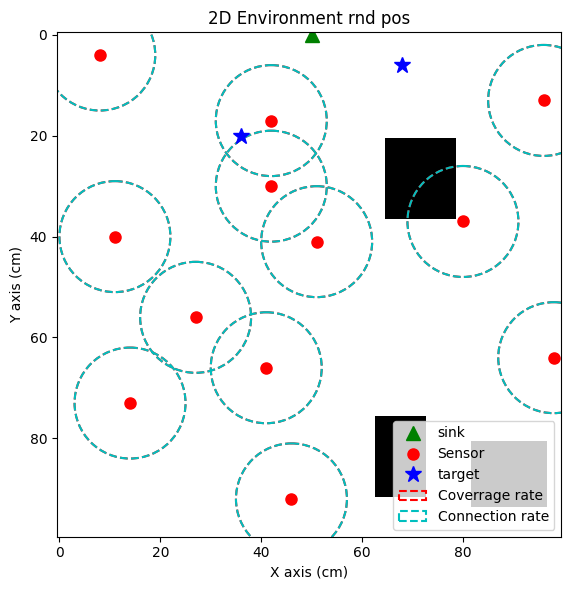

In [9]:
plot_2d_environment(Init_Environmet,
					cov_rate= Coverage_rate,
					con_rate= Connection_rate,
					edit= "rnd pos"
					 )


# Loss Function

$$ 
f(X) = \sum_{X}  || x_i - x_j ||_2 + \sum_{T} || x_i - t_i ||_2 - \lambda      \text{||E||} \\

X : \text{sensors positions} \\
T : \text{targer point positions} \\
E : \text{environmet obsticle}
$$

In [10]:


class WSNloss(nn.Module):
	def __init__(self,
				 env: Tensor, 
				 Coverage_rate: int | Tensor   = 3, 
				 Connection_rate: int | Tensor   = 3,
				 eps: float = 1e-1,
				 target_points: Tensor | None = None, 
				 sink_point: Tensor | None = None,
				 obstacle_weight:  Tensor  = torch.tensor(1.), 
				 intra_weight:  Tensor = torch.tensor(1. ), 
				 target_weight:  Tensor = torch.tensor(1.)
				) -> None:
		
		super(WSNloss, self).__init__()

		self.R_cov: Tensor = torch.tensor(Coverage_rate) - eps
		self.R_con: Tensor = torch.tensor(Connection_rate) - eps
		self.sink_point: Tensor | None = torch.tensor(sink_point) if sink_point is not None else None
		
		
		# مدیریت نقاط هدف
		if target_points is not None:
			self.target_points: Tensor = target_points
		else:
			self.target_points = None # type: ignore
			
		self.obstacle_weight: Tensor = obstacle_weight
		self.intra_weight: Tensor = intra_weight
		self.target_weight: Tensor = target_weight

		torch.nn.Parameter(self.obstacle_weight)
		torch.nn.Parameter(self.intra_weight)
		torch.nn.Parameter(self.target_weight)

		self.eps: Tensor = torch.tensor(eps)

		# محیط و کانولوشن موانع
		self.env: Tensor = env.float()
		# kernel_size: int = 2 * Coverage_rate + 1
		# self.conv = nn.Conv2d(1, 1, kernel_size, padding='same', bias=False)
		# nn.init.constant_(self.conv.weight, 1.0)
		# self.conv.requires_grad_(False)

	def forward(self, X: Tensor) -> Tensor:
		"""
		محاسبه تابع ضرر با در نظر گرفتن:
		1- فاصله بین سنسورها
		2- پوشش نقاط هدف
		3- اجتناب از موانع
		"""

		if_choised = X[...,2]
		X = X[:, :2]
		# print("if_choised ", if_choised.shape)
		# ==================== 1.1 Intra-Node (distance) ====================
		intra_dists: Tensor = torch.cdist(X, X, p=2)
		overlap_mask: Tensor = 1. - torch.eye(X.shape[0])
		intra_loss: Tensor = F.sigmoid(self.R_con - intra_dists) * overlap_mask
		
		# ==================== 1.2 Intra-Node (Overlap) ====================
		overlap_loss: Tensor = 1. - (F.sigmoid(self.eps - intra_dists) * overlap_mask)

		# choosed_loss = (if_choised).T
		# print(choosed_loss[choosed_loss <= 0])
		# print(f"{intra_loss.shape} @ {choosed_loss.shape} = {(intra_loss + choosed_loss).shape }")
		# ==================== 1.3 Intra-Node (Total) ====================
		intra_loss_t: Tensor = intra_loss  + overlap_loss

		
		# ==================== 2.1 Target Point ====================
		target_loss = torch.tensor(0.0 , requires_grad=True)
		if self.target_points is not None:
			target_dists: Tensor = torch.cdist(X, self.target_points, p=2)
			target_loss: Tensor = F.sigmoid(self.R_cov - target_dists ) 
		
		# ==================== 2.1 Sink Point ====================
		intra_sink_loss = torch.tensor(0.0 , requires_grad=True)
		if self.sink_point is not None:
			node_to_sink: Tensor = torch.cdist(X, self.sink_point, p=2)
			intra_sink_loss: Tensor = F.sigmoid( self.R_cov - node_to_sink)

		
		# print(f"{target_loss.shape} = {intra_loss.shape} + {intra_loss2.shape} . {intra_sink_loss.shape} * {target_loss.shape}")
		
		# ==================== 3.1 obstacle loss  ====================
		# تبدیل مختصات به اندیس‌های محیط
		h, w = self.env.shape
		coords = X[:, :2].clone()
		coords[:, 0] = torch.clamp((coords[:, 0] * w).long(), 0, w-1)
		coords[:, 1] = torch.clamp((coords[:, 1] * h).long(), 0, h-1)	
		# محاسبه جریمه موانع
		coords = coords.int()
		obstacle_penalty = self.env[coords[:, 1], coords[:, 0]].sum()
		
		# ==================== 3.2 Penalty out of env ====================
		out_of_bounds: Tensor = ((X < 0) | (X > 1)).any(dim=1)
		boundary_penalty: Tensor = out_of_bounds.float()
		obstacle_loss: Tensor = obstacle_penalty + boundary_penalty

		# ==================== Total Loss ====================
		# print(f"itra: {intra_loss_t.shape} | target: {target_loss.shape} | sink: {intra_sink_loss.shape} | obstacle: {obstacle_loss.shape} ")
		# print(f"itra: {intra_loss_t.mean(1).shape} | target: {target_loss.mean(1).shape} | sink: {intra_sink_loss.mean(0).shape} | obstacle: {obstacle_loss.mean(0).shape} ")
		# print(target_loss.shape, target_loss.mean(0).shape )
		loss_total: Tensor = (self.intra_weight    *  intra_loss_t.mean(1)) 	+\
							 (self.target_weight   *  target_loss.mean(1)) 		+\
							 (self.intra_weight    *  intra_sink_loss.mean(0))  +\
							 (self.obstacle_weight *  obstacle_loss)
							# (self.intra_weight    *  choosed_loss) +\
		
		# loss_total : Tensor = ((intra_loss_t @ target_loss) + intra_sink_loss).mean() + obstacle_loss
		# print(loss_total.shape) => [n_sensor]
		return loss_total #.mean()


# Traditional Evolutionary Method

In [11]:
class DCPMK(Problem):
	def __init__(self, 
				 pop: Tensor, 
				 env: Tensor,
				 target_points: Tensor | None, 
				 fitness_fn: nn.Module,
				 )-> None:

		self.pop_size, self.n_sensors, self.ndim = pop.shape
		
		super(DCPMK, self).__init__(
			n_var =  self.n_sensors * self.ndim,
			n_obj= self.n_sensors,
			n_ieq_constr=0,
			n_iter = 1,
			n_gen = self.pop_size,
			xl=0.0,
			xu=1.0
		)

		self.env = env.detach().clone()
		# self.pos = pop.detach().clone()
		self.target_points = target_points.detach().clone() if target_points is not None else None

		self.fitness_fn = fitness_fn

	def _evaluate(self, 
			   X, 
			   out,
			   *args,
			   **kwargs) -> None:

		X_tensor : Tensor = torch.tensor(X, dtype=torch.float32, requires_grad=False).\
			reshape(-1, self.n_sensors, self.ndim)
		# Reshape to (pop_size, n_sensors, ndim)

		losses = []
		for i in range(X_tensor.shape[0]):
			# Denormalize positions to environment size
			# X_denorm = denormalize_positions(X_tensor[i], self.env.shape)
			loss : Tensor = self.fitness_fn(X_tensor[i]).detach()
			# print(loss)
			losses.append(loss)
			
		# print(losses)
		out["F"] = torch.stack(losses).reshape(-1, Num_Sensor_Node)

In [12]:
# from pymoo.termination import get_termination
from typing import Self


class EvolutionAdaptation:
	def __init__(self,
	population : Tensor,
	new_env : Tensor,
	target_points : Tensor | None,
	fitness_fn : nn.Module,
	pos_init : Tensor ,
	cross_over_rate : float | int = 1,
	mutation_over_rate : float | int = 1,
	n_gen : int = 50
	) -> None:
		"""
		population: تنسور با اندازه (pop_size, n_sensors, ndim)
		new_env: محیط جدید به صورت تنسور
		target_points: نقطه هدف جدید به صورت تنسور
		fitness_fn: تابع هزینه برای ارزیابی موقعیت‌ها
		cross_over_rate: نرخ تقاطع برای الگوریتم ژنتیک
		mutation_over_rate: نرخ جهش برای الگوریتم ژنتیک
		pos_init: موقعیت اولیه به صورت تنسور
		n_iter: تعداد تکرارها برای الگوریتم ژنتیک
		"""
		# Ensure population is (pop_size, n_sensors * ndim)
		self.pop_size, self.n_sensors, self.ndim = population.shape
		population = population.reshape(-1, self.n_sensors * self.ndim)


		self.population = population
		self.new_env = new_env
		self.new_target_points = target_points
		self.fitness_fn = fitness_fn
		self.cross_over_rate = cross_over_rate
		self.mutation_over_rate = mutation_over_rate
		self.pos_init = pos_init
		self.n_gen = n_gen
		# Ensure pos_init is 2D  or 3D 
		# pos_init = input_tensor.clone().detach()
		pass
	def __call__(self : Self,
			  population : Tensor
			  ) -> Result:
		"""
		n_gen: تعداد تکرارها برای الگوریتم 
		"""
		# Ensure population is (pop_size, n_sensors * ndim)
		# print(f"population.shape {population.shape}")
		pop_numpy = population .reshape(-1, 
					 population.shape[0] * population.shape[1])

		# Define GA algorithm
		# print(f"pop_numpy.shape {pop_numpy.shape}")
		algorithm = PSO(
			pop_size= pop_size, 
			n_offsprings = None, 
			w= 1.,
			c1 = 2.,
			c2= 2.,
			adaptive=True,
			n_diffs = 1,
			archive=None,
			crossover=SBX(eta=1, prob= self.cross_over_rate),
			mutation=PM(eta=1, prob= self.mutation_over_rate),
			n_gen = 1,
			n_iter = 1
		)

		# Define problem
		problem = DCPMK(
			pop=self.pos_init,
			env=self.new_env,
			target_points=self.new_target_points,
			fitness_fn= self.fitness_fn,

		)
		from pymoo.termination.robust import RobustTermination
		from pymoo.termination.max_gen import MaximumGenerationTermination

		termination = RobustTermination(
			MaximumGenerationTermination(1),
			# MultiObjectiveSpaceTermination(tol=0.005, n_skip=5), 
			period=1)

		# Termination().update (algorithm)
		# Run optimization
		res = minimize(
			problem,
			algorithm,
			X=pop_numpy,  # ← مقدار اولیه
			termination= termination, 
			seed=SEED,
			save_history=False,
			save_archive=False,
			verbose=False,
			return_least_infeasible=False
		)

		# print("res " , res.X.shape)
		# print(res.algorithm.n_gen, res.algorithm.n_iter )
		return res

# make network

In [13]:
class NetWorkAdapter(nn.Module):
	def __init__(self,num_pop: int,
				   num_sensor : int,
				  dimension : int ,
					 *args, **kwargs) -> None:
		
		super().__init__(*args, **kwargs)
		
		self.input_size : int = dimension
		self.num_pop: int = num_pop
		self.num_sensor: int = num_sensor
		
		# self.fc1 = nn.Sequential(
		# 	nn.Linear(in_features=dimension, out_features=16),
		# 	nn.ReLU(),
		# 	nn.Linear(in_features=16, out_features=32),
		# 	nn.ReLU(),
		# 	nn.Linear(in_features=32, out_features=8),
		# 	nn.ReLU()
			
		# )
		# self.h0 = torch.randn(num_pop,24,  32)
		# self.c0 = torch.randn(num_pop, 24, 32)

		self.lstm = nn.LSTM(input_size = dimension, 
							hidden_size = dimension, 
							num_layers = 10, 
							batch_first=True,
							bidirectional=False)
		# self.fc2 = nn.Sequential(
		# 			nn.ReLU(),
		# 			nn.Linear(in_features=16, out_features=dimension),
		# 			nn.Sigmoid(),
		# 			# nn.Linear(in_features=64, out_features=input_size),
		# 			# nn.Sigmoid()
		# 					)
		pass

	def forward(self, x : Tensor) -> Tensor:
		# x = self.fc1(x)
		rnn, _ = self.lstm(x)
		# print(rnn.shape)
		# x = self.fc2( rnn )
		return rnn.sigmoid()

# Define Model

In [14]:
# تعریف مدل و تابع ضرر

# Define the fitness function
fitness_fn = WSNloss(
    env= Environmet,
	Coverage_rate= Coverage_rate,
    Connection_rate= Connection_rate,
	
	target_points=target_points[0],
	sink_point= SINK_POSITION, 
    intra_weight = intra_weight,	
	target_weight = target_weight,
	obstacle_weight = obstacle_weight ,
    eps = 1e-1,
	
)

model_loss : MSELoss = MSELoss()
# Define the network adapter
learning_model : NetWorkAdapter = NetWorkAdapter(pop_size, 
												  Num_Sensor_Node,
												  Dimension+1)

# Define the optimizer
optimizer = Adam(learning_model.parameters(), 
				lr= Learning_rate,
				# alpha=.5,
				eps=1e-8,
				# centered=True,
				# momentum=0.5,
				weight_decay=1e-2,
				maximize= False
				)
# Define the evolution adaptation
evolution_adpator = EvolutionAdaptation(
	population=Sensor_Nodes,
	new_env=Environmet,
	target_points=target_points,
	fitness_fn=fitness_fn,
	pos_init=Sensor_Nodes,
	cross_over_rate=0.5,
	mutation_over_rate=0.5,
	n_gen=1
)


print(f"""
Loss Function: {fitness_fn}
{25*'-'}
NetWorks: {learning_model}
{25*'-'}
Optimizer: {optimizer}
{25*'-'}
Network Adapter: {learning_model}
""")

C:\Users\Nemo\AppData\Local\Temp\ipykernel_16976\1247914926.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.R_cov: Tensor = torch.tensor(Coverage_rate) - eps
C:\Users\Nemo\AppData\Local\Temp\ipykernel_16976\1247914926.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.R_con: Tensor = torch.tensor(Connection_rate) - eps
C:\Users\Nemo\AppData\Local\Temp\ipykernel_16976\1247914926.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sink_point: Tensor | None = torch.tensor(sink_point) if sink_point is not None else None


Loss Function: WSNloss()
-------------------------
NetWorks: NetWorkAdapter(
  (lstm): LSTM(3, 3, num_layers=10, batch_first=True)
)
-------------------------
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.05
    maximize: False
    weight_decay: 0.01
)
-------------------------
Network Adapter: NetWorkAdapter(
  (lstm): LSTM(3, 3, num_layers=10, batch_first=True)
)



In [15]:
params = torch.tensor(0.0)

for name, param in learning_model.named_parameters():
	params += param.size().numel()
	# print(name, param.size(),)

params

tensor(960.)

In [16]:
def train_model(
				X : Tensor, 
				y : Tensor,
				epoch : int = 1):
	
	for _ in range(epoch):
		optimizer.zero_grad()
		output: Tensor = learning_model(X)
		loss: Tensor = model_loss(output, y)
		loss.backward(gradient = torch.ones_like(loss))
		torch.nn.utils.clip_grad_norm_(learning_model.parameters(), max_norm=1.0)
		optimizer.step()
		
	return loss

# Runing Functions

In [17]:
# Define the network adaptation function
def network_adapt(
	input_tensor: Tensor,
) -> tuple[Tensor, Tensor]:
	
	output_list: list[Tensor] = list()
	loss_list: list[Tensor] = list()
	learning_model.train()
	# for sample in input_tensor:
	output : Tensor = learning_model(input_tensor)
	loss : Tensor = fitness_fn(output)
	output_list.append(output)
	loss_list.append(loss)


	return torch.stack(output_list), torch.stack(loss_list)  # output, loss


In [18]:
# Define the evolution adaptation function
def evolution_adpat(
		input_tensor : Tensor, 
	) -> tuple[Tensor, Tensor]:
	"""
	input_tensor: تنسور ورودی با اندازه (pop_size, n_sensors, ndim)
	n_iter: تعداد تکرارها برای الگوریتم 
	"""
	result : Result = evolution_adpator(input_tensor, )
	# print("result.X \n", result.X[-1])
	optimized_positions : Tensor = torch.tensor(result.X[-1], # type: ignore
											 requires_grad=True).float().reshape( Num_Sensor_Node, Dimension+1) # type: ignore
	
	F : Tensor = torch.tensor(result.F, requires_grad=True) # type: ignore #.reshape(-1, X, 2)

	# optimized_positions_denorm = denormalize_positions(optimized_positions , ENV_SIZE)
	return optimized_positions , F



# Run Simulation

In [19]:
print(f"""
Sensor_Nodes: {Sensor_Nodes.shape}
target points: {target_points[0].shape}
sink : {denorm_sink}
Environmet: {Environmet.shape}
""")


Sensor_Nodes: torch.Size([100, 20, 3])
target points: torch.Size([2, 2])
sink : tensor([[ 0., 50.]])
Environmet: torch.Size([100, 100])



In [20]:
from collections import deque

archiveLen : int = 100

ft_dure_gen : list = list()
loss_dure_archive = list()
losses : list = list()
archive: deque[Tensor]  =  deque(maxlen=archiveLen)
time_to_run = list()

torch.autograd.set_detect_anomaly(False)
firstX = Sensor_Nodes.clone()
# print(f"firstX.shape {firstX.shape}")

for gen in range(n_simu):
	start_time: float = time.time()

	head = torch.rand(1).item() < chance_in_net_favor   

	for PopX in firstX:
		if head and gen > 1:
			# print("Network Adaptation")
			newX, newX_fitness = network_adapt(PopX)
		else:
			# print("Evolution Adaptation")
			# print(f"newX {newX.shape}")
			newX, newX_fitness = evolution_adpat(PopX)
			# print(newX)
			# print(f"newX.shape {newX.shape}\n newX_fitness.shape {newX_fitness.shape}")
			
		# Seperation
		# for f in range(len(newX_fitness)):
			if torch.any(
					(fitness_fn(newX)) < \
					(fitness_fn(PopX))
						):
				archive.append(
					torch.stack(
						(PopX.detach().clone().requires_grad_(), 
						newX.detach().clone().requires_grad_())
								)
								)
				
			# firstX = newX
		# else:
		# 	archive.append(PopX.detach().clone().requires_grad_())
		# popX = newX

	for x1, x2  in archive:
		# print(f"{type(x1), type(x2)}")
		losse_prime = train_model(x1, x2 , epoch=1)
		loss_dure_archive.append(losse_prime.item())





	end_time = time.time()
	time_delay = (end_time - start_time) * 1000 
	time_to_run.append(time_delay)
		
	ft_dure_gen.append(newX_fitness.mean().item())


	print(f"Gen {gen+1} | Arch Size {len(archive)} | fitness {newX_fitness.mean().item(): .4f} | loss {torch.tensor(loss_dure_archive).mean().item():.4f} | {"'NET'" if head and gen > 1 else "'EA'"} ")
	# break










Gen 1 | Arch Size 100 | fitness  2.5708 | loss 0.0832 | 'EA' 
Gen 2 | Arch Size 100 | fitness  2.5701 | loss 0.0835 | 'EA' 
Gen 3 | Arch Size 100 | fitness  2.4519 | loss 0.0836 | 'NET' 
Gen 4 | Arch Size 100 | fitness  2.5729 | loss 0.0829 | 'EA' 
Gen 5 | Arch Size 100 | fitness  2.4513 | loss 0.0825 | 'NET' 
Gen 6 | Arch Size 100 | fitness  2.5700 | loss 0.0824 | 'EA' 
Gen 7 | Arch Size 100 | fitness  2.4515 | loss 0.0824 | 'NET' 
Gen 8 | Arch Size 100 | fitness  2.4515 | loss 0.0823 | 'NET' 
Gen 9 | Arch Size 100 | fitness  2.4515 | loss 0.0823 | 'NET' 
Gen 10 | Arch Size 100 | fitness  2.5708 | loss 0.0824 | 'EA' 
Gen 11 | Arch Size 100 | fitness  2.5738 | loss 0.0826 | 'EA' 
Gen 12 | Arch Size 100 | fitness  2.4514 | loss 0.0827 | 'NET' 
Gen 13 | Arch Size 100 | fitness  2.5724 | loss 0.0827 | 'EA' 
Gen 14 | Arch Size 100 | fitness  2.5718 | loss 0.0826 | 'EA' 
Gen 15 | Arch Size 100 | fitness  2.4516 | loss 0.0826 | 'NET' 
Gen 16 | Arch Size 100 | fitness  2.5697 | loss 0.0826 | 

# Visulizing Result

In [21]:
archive = list(archive)
print(len(archive))
print(archive[0].shape) 
print(archive[2].shape)

100
torch.Size([2, 20, 3])
torch.Size([2, 20, 3])


In [22]:
tensor_archive= torch.stack(archive).reshape(-1,Num_Sensor_Node, Dimension+1)

# archive= torch.stack([torch.stack([a.detach()]) for a in archive])#.reshape(-1,Num_Sensor_Node, 2)

tensor_archive.shape

torch.Size([200, 20, 3])

In [23]:
tensor_list = [denormalize_positions(arc , ENV_SIZE).detach()
			   for arc in tensor_archive]

# filter Tensors with atleast 1 element
filtered = [t for t in tensor_list if t.numel() > 0 and t.shape[0] > 0]

# into a big Tensor
if filtered:
	combined = torch.cat(filtered, dim=0)
else:
	# if There's none
	combined = torch.empty((0, tensor_list[0].shape[1]))  # یا مثلا (0, D)
	

# print(filtered)
# print(combined.shape)

In [24]:

# best_denorm = [denormalize_positions(arc , ENV_SIZE).detach()
# 			   for arc in tensor_archive]
# # print(best_denorm.shape)
best_answer = find_best(filtered, fitness_fn,best_as= 'min', verbose=True)

print(f"Best Answer is:\n{best_answer}")
opt_env = positioning_nodes(Environmet, 
							best_answer, 
							defines_as=2)


Best Answer is in index: 136
Best Answer is:
tensor([[22.0450, 63.6239,  1.0000],
        [46.9398,  6.8780,  1.0000],
        [69.9392, 33.3902,  1.0000],
        [78.0681, 60.9037,  1.0000],
        [22.8653, 22.1521,  1.0000],
        [59.2127, 57.9375,  1.0000],
        [ 2.1271, 81.7670,  1.0000],
        [96.6481, 32.9931,  1.0000]])


In [25]:
print(f"""
mean {best_answer[...,2].mean():.4f}
std {best_answer[...,2].std()  :.4f}
threashold {best_answer[...,2].mean() + best_answer[...,2].std():.4f}
max {best_answer[...,2].max() :.4f}
min {best_answer[...,2].min()    :.4f}
median {best_answer[...,2].median() :.4f}

""")


mean 1.0000
std 0.0000
threashold 1.0000
max 1.0000
min 1.0000
median 1.0000




In [26]:
# print(best_answer.shape)
print(f"""
Optimized Env has - {torch.count_nonzero(opt_env == 2)} - Sensors placed in the environment.
Optimized Env has - {torch.count_nonzero(opt_env == 3)} - Target placed in the environment.
Optimized Env has - {torch.count_nonzero(opt_env == 4)} - sink placed in the environment.
"""
)


Optimized Env has - 8 - Sensors placed in the environment.
Optimized Env has - 2 - Target placed in the environment.
Optimized Env has - 1 - sink placed in the environment.



## Best Env Optimized Find

In [27]:
print(f"""
sensors connected:
{Sup(best_answer, Connection_rate)}, {Sup(best_answer, Connection_rate).shape}
# ----------------
Targets Covered:
{Cov(best_answer, denorm_target_points, Coverage_rate)}, {Cov(best_answer, denorm_target_points, Coverage_rate).shape}
# ----------------
Sink Covered:
{Cov(best_answer, denorm_sink, Connection_rate)}, {Cov(best_answer, denorm_sink, Connection_rate).shape}
""") 




sensors connected:
tensor([[3, 5],
        [5, 3]]), torch.Size([2, 2])
# ----------------
Targets Covered:
tensor([], size=(0, 2), dtype=torch.int64), torch.Size([0, 2])
# ----------------
Sink Covered:
tensor([], size=(0, 2), dtype=torch.int64), torch.Size([0, 2])



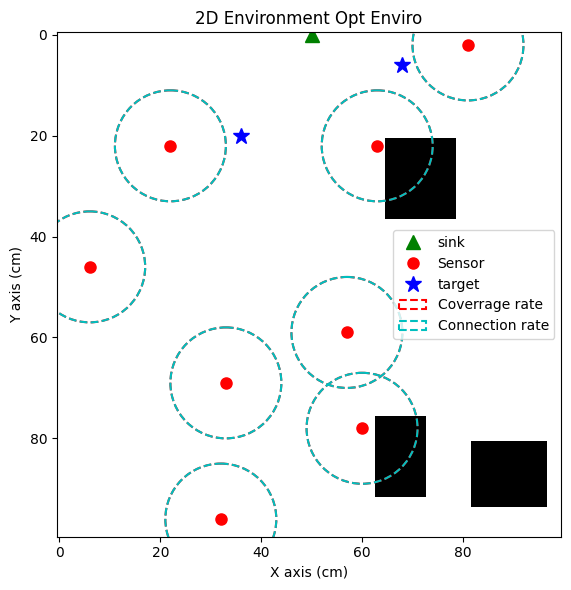

In [28]:
try:
	plot_2d_environment(opt_env,
					 cov_rate= Coverage_rate,
					 con_rate=Connection_rate, 
					 edit= 'Opt Enviro'
					 )
except Exception as e:
	print(f"Error in plotting environment: {e}")

## loss and fitness graphing

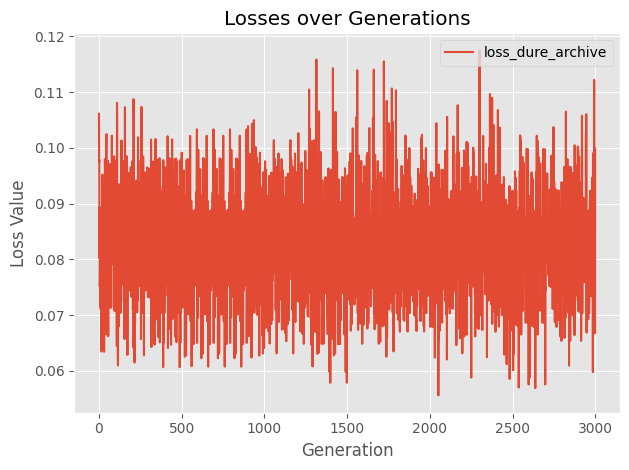

In [29]:
style.use("ggplot")
sns.lineplot({
			  "loss_dure_archive": loss_dure_archive})
plt.title("Losses over Generations")
plt.xlabel("Generation")
plt.ylabel("Loss Value")
handles, labels = plt.gca().get_legend_handles_labels()
if handles:
	plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

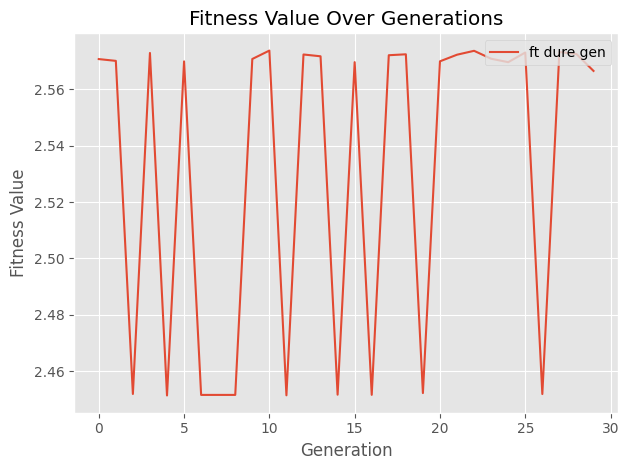

In [30]:
style.use("ggplot")
sns.lineplot({
	"ft dure gen":ft_dure_gen,})
plt.title("Fitness Value Over Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness Value")
handles, labels = plt.gca().get_legend_handles_labels()
if handles:
	plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

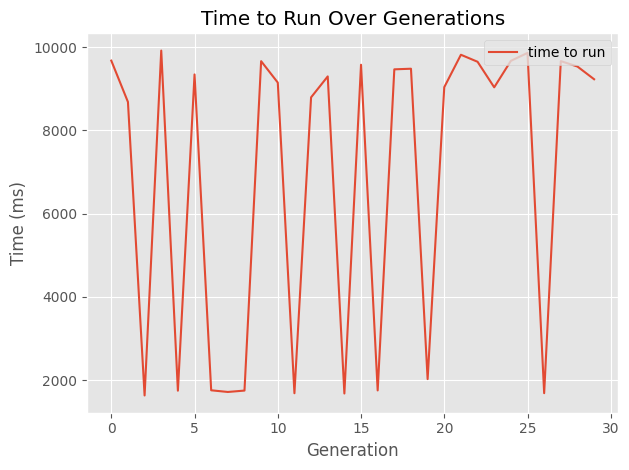

In [31]:
style.use("ggplot")
sns.lineplot({
			  "time to run": time_to_run
			  })
plt.title("Time to Run Over Generations")
plt.xlabel("Generation")

plt.ylabel("Time (ms)")
handles, labels = plt.gca().get_legend_handles_labels()
if handles:
	plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [32]:
# all_denoremd = [positioning_nodes(Environmet, node) for node in best_denorm]

# for i, envs in enumerate(all_denoremd):
# 	break
# 	try:
# 		plot_2d_environment(envs, 
# 						cov_rate=Coverage_rate,
# 						con_rate=Connection_rate,
# 						edit=f"Generation {i+1}")
# 	except Exception as e:
# 		print(f"Error in plotting generation {i+1}: {e}")
# 		break